# RTF Model for predicting Age with MFCC - Vibrations

Import

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.fftpack import dct

ReadCsv function

Colonnes du fichier P1_RB_1_C_1.csv : (2401, 1)


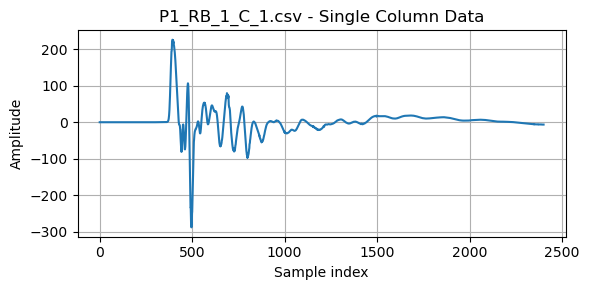

Colonnes du fichier P1_RB_1_C_2.csv : (2401, 1)


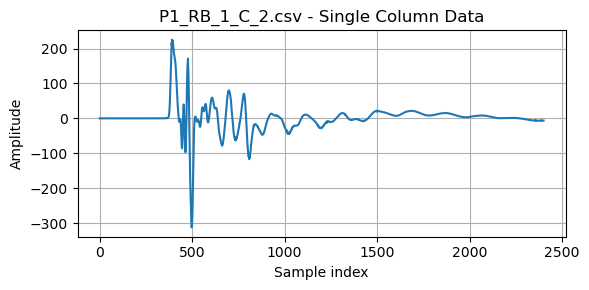

In [2]:
def readCsvFolder(folderPath):
    fileFolder = []
    files = []
    for filepath in glob.glob(os.path.join(folderPath, '*.csv')):
        try:
            data = pd.read_csv(filepath, header=None)  # On suppose pas d'en-têtes
            fileFolder.append(data)
            files.append(os.path.basename(filepath))
        except Exception as e:
            print(f"Erreur lors de la lecture de {filepath} : {e}")
    return fileFolder, files

# Lecture des fichiers
csv_data_list, filenames = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P1_clean/RB")

# Affichage
for i,csv_data in enumerate(csv_data_list[:2]):
    print(f"Colonnes du fichier {filenames[i]} :",csv_data.shape)

    plt.figure(figsize=(6, 3))
    if csv_data.shape[1] >= 2:
        time_axis = range(len(csv_data.iloc[:, 1]))  # Pas de vraie échelle de temps si on ne l'a pas
        plt.plot(time_axis, csv_data.iloc[:, 1], label="Amplitude")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
        plt.title(f"{filenames[i]} - Channel 1")
    else:
        plt.plot(csv_data.iloc[:, 0])
        plt.title(f"{filenames[i]} - Single Column Data")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Spectrum

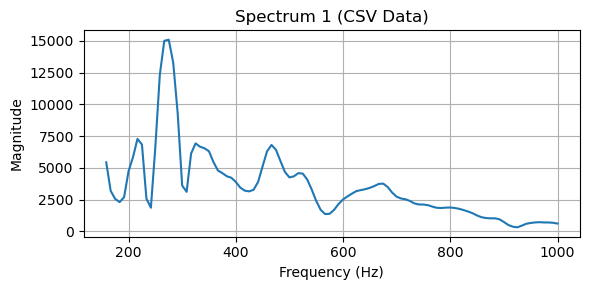

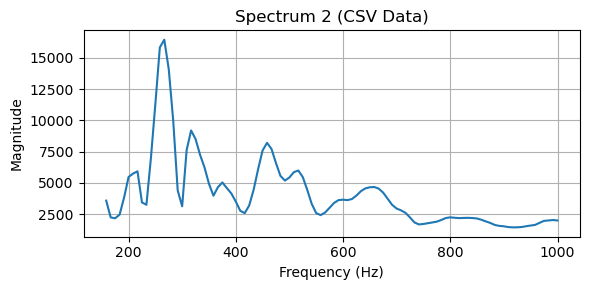

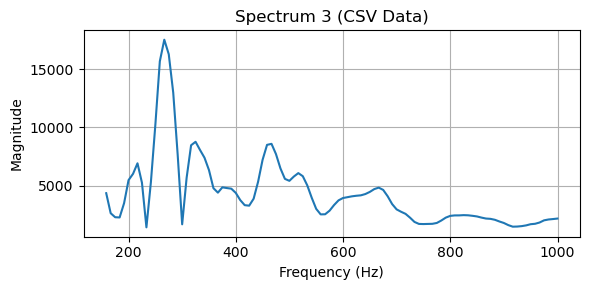

In [3]:
def spectrumFromCsv(csv_data, sample_rate):
    """Calcule le spectre à partir d'un signal CSV"""
    signal = csv_data.iloc[:, 0].values  # extrait la colonne souhaitée
    spectrum = fft(signal)
    magnitude = abs(spectrum[:len(spectrum) // 2])
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)[:len(spectrum) // 2]
    return freqs, magnitude

sample_rate = 20000

spectrumVect = []

for csv_data in csv_data_list:
    freqs, spectrum = spectrumFromCsv(csv_data, sample_rate)
    # Filtrage de la bande [150 Hz, 1000 Hz]
    band_mask = (freqs >= 150) & (freqs <= 1000)
    filtered_freqs = freqs[band_mask]
    filtered_spectrum = spectrum[band_mask]
    spectrumVect.append((filtered_freqs, filtered_spectrum))


# Visualisation des spectres pour les données CSV
for idx, (freqs, spectrum) in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs, spectrum)
    plt.title(f"Spectrum {idx + 1} (CSV Data)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Extract each peak and store

In [4]:
def extractNPeak(n_peak,signal):
    # Find peaks in the signal
    peaks = np.argsort(signal)[-n_peak:]  # Get indices of the n largest peaks
    peaks = np.sort(peaks)  # Sort the indices in ascending order

    # Extract the peak values
    peak_values = signal[peaks]

    return peaks, peak_values


# Fonction pour lire les fichiers d'un dossier donné
def lire_fichiers_dossier(dossier):
    if os.path.exists(dossier):  # Vérifier si le dossier existe
        return readCsvFolder(dossier)
    else:
        print(f"Dossier introuvable : {dossier}")
        return [], [], []  # Retourne des listes vides si le dossier n'existe pas
    
def compute_mfcc(csv_file, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=40):
    # Step 1: Compute the power spectrum
    window = np.hanning(n_fft)
    frames = [
        csv_file[i:i + n_fft] * window
        for i in range(0, len(csv_file) - n_fft, hop_length)
    ]
    power_spectrum = np.array([np.abs(np.fft.rfft(frame))**2 for frame in frames])

    # Step 2: Compute the Mel filterbank
    mel_filters = np.zeros((n_mels, n_fft // 2 + 1))
    mel_min = 0
    mel_max = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((n_fft + 1) * hz_points / sample_rate).astype(int)

    for i in range(1, n_mels + 1):
        mel_filters[i - 1, bin_points[i - 1]:bin_points[i]] = (
            np.linspace(0, 1, bin_points[i] - bin_points[i - 1])
        )
        mel_filters[i - 1, bin_points[i]:bin_points[i + 1]] = (
            np.linspace(1, 0, bin_points[i + 1] - bin_points[i])
        )

    # Step 3: Apply the Mel filterbank to the power spectrum
    mel_spectrum = np.dot(power_spectrum, mel_filters.T)

    # Step 4: Take the logarithm of the Mel spectrum
    log_mel_spectrum = np.log(mel_spectrum + 1e-10)

    # Step 5: Compute the DCT to get MFCCs
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

## Main

In [5]:
# Liste des types de raquettes et zones
raquetteTypeList = {"RB":0, "RO":1, "RR":2, "RV":3}
racket_ages = {"P1":1, "P2":2, "P3":3}

allCsvFile=[]
allCsvFileLabel=[]
allCsvFileP1=[]
allCsvFileP2=[]
allCsvFileP3=[]
results = []

for raquetteType in raquetteTypeList:
    #P1
    fileFolderP1,filesP1 = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P1_clean/"+raquetteType)
    fileFolderP1 = [df for df, path in zip(fileFolderP1, filesP1) if "_C" in os.path.basename(path)]
    allCsvFileP1.extend(fileFolderP1)

    #P2
    fileFolderP2,filesP2 = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P2_clean/"+raquetteType)
    fileFolderP2 = [df for df, path in zip(fileFolderP2, filesP2) if "_C" in os.path.basename(path)]
    allCsvFileP2.extend(fileFolderP2)

    #P3
    fileFolderP3,filesP3 = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P3_clean/"+raquetteType)
    fileFolderP3 = [df for df, path in zip(fileFolderP3, filesP3) if "_C" in os.path.basename(path)]
    allCsvFileP3.extend(fileFolderP3)


# Find the minimum length among the three lists
min_len = min(len(allCsvFileP1), len(allCsvFileP2), len(allCsvFileP3))

# Reduce each list to the minimum length
allCsvFileP1 = allCsvFileP1[:min_len]
allCsvFileP2 = allCsvFileP2[:min_len]
allCsvFileP3 = allCsvFileP3[:min_len]

print("Len(allCsvFileP1)",len(allCsvFileP1),"Len(allCsvFileP2)",len(allCsvFileP2),"Len(allCsvFileP3)",len(allCsvFileP3))


# print(len(sampleRateFolderP1))

for csvFile in allCsvFileP1:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("P1")
for csvFile in allCsvFileP2:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("P2")
for csvFile in allCsvFileP3:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("P3")

    
for bd in range(10,101,5):

    mfcc_features = []

    for csvFile in allCsvFile:
        # Compute the spectrum using FFT
        signal = csvFile.iloc[:, 0].values  # On prend la première colonne de chaque fichier
        mfccs = compute_mfcc(signal, sample_rate)  # Calcul des MFCC

        # Ajouter les MFCC calculés à la liste des caractéristiques
        mfcc_features.append(mfccs.flatten())  # Aplatir les MFCC pour avoir un vecteur d'entrée
    
    # Combiner les caractéristiques MFCC dans X
    X = np.array(mfcc_features)

    # Encode string labels into integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(allCsvFileLabel)

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Définir les bonnes valeurs trouvé
    n_estimators_range = [10, 50, 100]
    max_depth_range = [None, 10, 20, 30]
    min_samples_split_range = [2, 5, 10]

    # Tester toutes les combinaisons d'hyperparamètres
    for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for min_samples_split in min_samples_split_range:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                rf.fit(X_train, y_train)
                # Évaluer sur l'ensemble de test
                y_pred = rf.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_pred)

                # Évaluer sur l'ensemble d'entraînement
                y_train_pred = rf.predict(X_train)
                accuracy_train = accuracy_score(y_train, y_train_pred)

                results.append({
                    'band_width': bd,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })
                
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
results_df.to_excel("V_RTF_Age_P1.P2.P3_MFCC.xlsx", index=False)

print("Results have been saved to 'V_RTF_Age_P1.P2.P3_MFCC.xlsx'.")
      
# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

Len(allCsvFileP1) 72 Len(allCsvFileP2) 72 Len(allCsvFileP3) 72
Results have been saved to 'V_RTF_Age_P1.P2.P3_MFCC.xlsx'.
     band_width  n_estimators  max_depth  min_samples_split  accuracy_train  \
342          55            50       20.0                  2        1.000000   
48           15            50        NaN                  2        1.000000   
417          65            50       30.0                  2        1.000000   
129          25            50       30.0                  2        1.000000   
126          25            50       20.0                  2        1.000000   
..          ...           ...        ...                ...             ...   
491          75            50       30.0                 10        0.994186   
494          75           100        NaN                 10        0.994186   
92           20            50       20.0                 10        0.994186   
497          75           100       10.0                 10        0.994186   
683      

Extract peaks

In [6]:
bestPeakHZAllCsvFile = []
bestPeakAmplitudeAllCsvFile = []
n_peak = 25

for csvFile in allCsvFile:
    # Compute the spectrum using FFT
    freqs, spectrum = spectrumFromCsv(csvFile, sample_rate)

    # Extract peaks from the spectrum
    peaks_HZ, peak_Amplitude = extractNPeak(n_peak, spectrum)
    bestPeakHZAllCsvFile.append(peaks_HZ)
    bestPeakAmplitudeAllCsvFile.append(peak_Amplitude)

    # Normaliser les amplitudes
    bestPeakAmplitudeAllCsvFile = [amp / np.max(amp) for amp in bestPeakAmplitudeAllCsvFile]

In [7]:
# Combine features into X
X = np.hstack([np.array(bestPeakHZAllCsvFile), np.array(bestPeakAmplitudeAllCsvFile)])

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allCsvFileLabel)

# Diviser les données en ensembles d'entraînement et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Définir les bonnes valeurs trouvé
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

results = []

# Tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_train_pred = rf.predict(X_train)

            results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_score(y_train, y_train_pred),
                'accuracy_test': accuracy_score(y_test, y_pred)
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
results_df.to_excel("RTF_AGE_P1.P2.P3_MFCC.xlsx", index=False)

print("Results have been saved to 'RTF_AGE_P1.P2.P3_MFCC.xlsx'.")

# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

Results have been saved to 'RTF_AGE_P1.P2.P3_MFCC.xlsx'.
    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
10            10       30.0                  5        0.982558       0.772727
25           100        NaN                  5        1.000000       0.772727
34           100       30.0                  5        1.000000       0.772727
33           100       30.0                  2        1.000000       0.772727
4             10       10.0                  5        0.982558       0.772727
1             10        NaN                  5        0.982558       0.772727
31           100       20.0                  5        1.000000       0.772727
7             10       20.0                  5        0.982558       0.772727
30           100       20.0                  2        1.000000       0.772727
24           100        NaN                  2        1.000000       0.772727
28           100       10.0                  5        1.000000       0.772727
15     

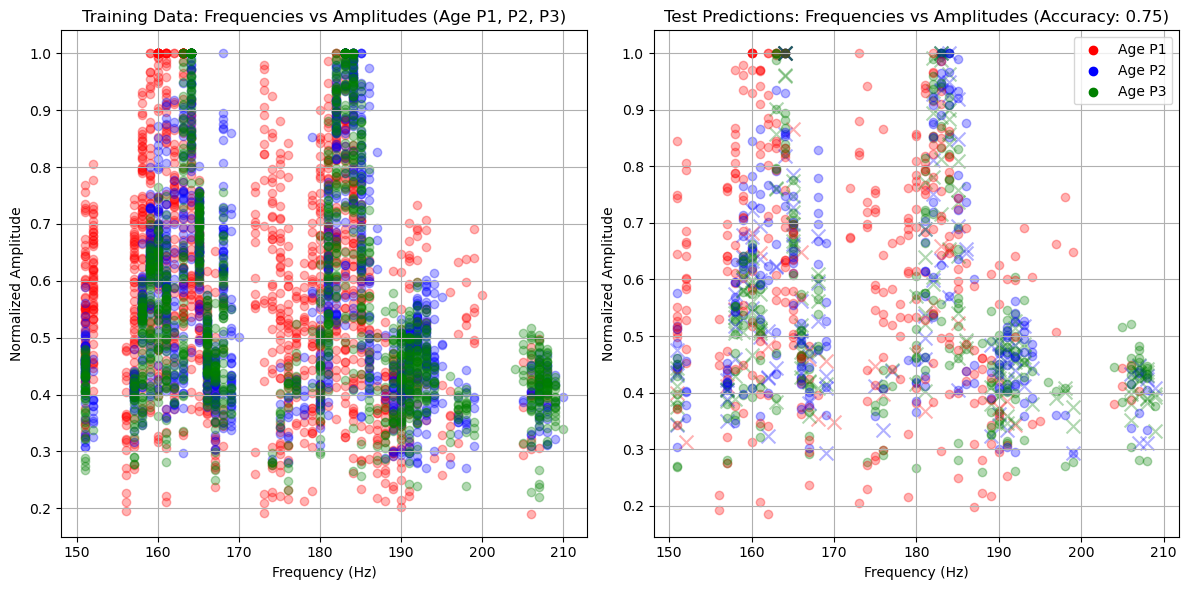

In [9]:
# Define a color map for the labels
colors = ['red', 'blue', 'green']
ageList = {"P1": 1, "P2": 2, "P3": 3}
label_names = list(ageList.keys())

# Create a scatter plot for the training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # First subplot for training data
for label_idx, label_name in enumerate(label_names):
    # Filter data points for the current label
    label_data = X_train[y_train == label_idx]
    for sample in label_data:
        # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
        frequencies = sample[:n_peak] + 150
        amplitudes = sample[n_peak:]
        mask = frequencies <= 550
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[label_idx], alpha=0.3)

plt.title("Training Data: Frequencies vs Amplitudes (Age P1, P2, P3)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

# Create a scatter plot for the test data with predictions
plt.subplot(1, 2, 2) # Second subplot for test data with predictions
y_pred = rf.predict(X_test) # Get predictions for test data

for i, sample in enumerate(X_test):
    true_label = y_test[i]
    pred_label = y_pred[i]

    # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
    frequencies = sample[:n_peak] + 150
    amplitudes = sample[n_peak:]
    mask = frequencies <= 550

    # Plot with solid color if prediction is correct, otherwise use a different marker
    if true_label == pred_label:
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], alpha=0.3)
    else:
        # Use 'x' marker for incorrect predictions
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], marker='x', s=100, alpha=0.3)

# Add a legend
for label_idx, label_name in enumerate(label_names):
    plt.scatter([], [], color=colors[label_idx], label=f"Age {label_name}")

plt.legend()
plt.title(f"Test Predictions: Frequencies vs Amplitudes (Accuracy: {accuracy_score(y_test, y_pred):.2f})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

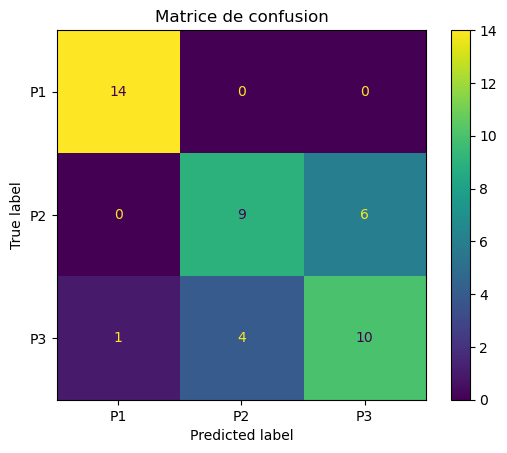

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()